<a href="https://colab.research.google.com/github/SPThole/pyTrch/blob/master/share_price_predictions_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from tqdm.notebook import tqdm
import torch.nn as nn
import yfinance as yf
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
today_date = date.today()
today_date = str(today_date)

In [5]:
company = 'TSLA'
getit = yf.Ticker(company)

data = getit.history(period='1y')

In [6]:
#already in date time format
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2019-10-03 to 2020-10-02
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          253 non-null    float64
 1   High          253 non-null    float64
 2   Low           253 non-null    float64
 3   Close         253 non-null    float64
 4   Volume        253 non-null    int64  
 5   Dividends     253 non-null    int64  
 6   Stock Splits  253 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 15.8 KB


In [7]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-10-03,46.37,46.90,44.86,46.61,75422500,0,0.0
2019-10-04,46.32,46.96,45.61,46.29,39975000,0,0.0
2019-10-07,45.96,47.71,45.71,47.54,40321000,0,0.0
2019-10-08,47.17,48.79,46.90,48.01,43391000,0,0.0
2019-10-09,48.26,49.46,48.13,48.91,34472000,0,0.0


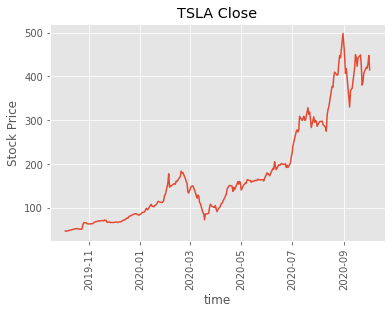

In [8]:
colp = 'Close'

plt.style.use('ggplot')

plt.plot(data['Close'])
plt.xticks(rotation = 'vertical')
plt.title(company + ' ' + colp)
plt.xlabel('time')
plt.ylabel('Stock Price')
plt.show()

In [9]:
input = torch.randn(12,100,1)
lstm = nn.LSTM(input_size = 1, hidden_size =512 , batch_first = True)

output, _ =lstm(input)

In [10]:
output.reshape(100, 12, 512)[-1].shape

torch.Size([12, 512])

In [11]:
scaler = MinMaxScaler()

hist_data = data['Close'].values

hist_data = scaler.fit_transform(hist_data.reshape(-1,1))

In [12]:
def slider_timeframe(window_size,data):

  vals = data.copy()


  xs = []
  ys = []

  for i in range(0,len(vals)-window_size):

    xs.append(vals[i:i+window_size])
    ys.append(vals[i+window_size])

  return np.array(xs),np.array(ys)

In [13]:


window_size = 5
x,y = slider_timeframe(window_size,hist_data)


In [14]:
x.shape,y.shape

((248, 5, 1), (248, 1))

In [15]:
x_train_size = int(0.75*len(x))

x_test_size = len(x) -x_train_size

scaler = MinMaxScaler()

x_train = x[:x_train_size]

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y[:x_train_size]).float()

x_test = x[x_train_size:]

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y[x_train_size:]).float()

In [16]:
x_test.shape, y_train.shape

(torch.Size([62, 5, 1]), torch.Size([186, 1]))

In [17]:
class tsData(Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y

  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

  def __len__(self):
    return len(self.x)

In [18]:
class tsmodel(nn.Module):

  def __init__(self,
               features,
               horizon,
               seq_len,
               hidden_size,
               num_layers):
    
    super(tsmodel,self).__init__()

    self.features = features
    self.horizon = horizon
    self.seq_len = seq_len
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.rnn = nn.LSTM(input_size = self.features, 
                       hidden_size = self.hidden_size, 
                       dropout = 0.4,
                       num_layers = self.num_layers,
                       
                       )
    
    self.linear = nn.Linear(self.hidden_size,
                            self.horizon)

  def forward(self,x):

    h_0 = torch.zeros(self.num_layers, self.seq_len, self.hidden_size).to(device)
    c_0 = torch.zeros(self.num_layers, self.seq_len, self.hidden_size).to(device)
    
    out,_ = self.rnn(x,(h_0,c_0))

    #print(out.shape)

    out = out.reshape(self.seq_len, x.size(0), self.hidden_size)

    #print(out[-1].shape)

    out = self.linear(out[-1])

    #print(out.shape)

    return out


In [19]:
TSmodel = tsmodel(1, 1, window_size, 512, 1).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [20]:
optimizer = torch.optim.Adam(TSmodel.parameters(),lr=1e-3)

loss_func = nn.MSELoss().to(device)

In [21]:
def trainer(model, loader, optimizer,epoch):
  l = []
  for i, X in enumerate(loader):
     
  

    x, y = X

    x = x.to(device)
    y = y.to(device)

    output = model(x)

    loss = loss_func(output, y)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

    l.append(loss.item())
  
  if epoch%50==0:
    print('__________________________________________________\n')
    print(f'Training loss\t\t\t {np.mean(l)}')
    print('__________________________________________________\n')

def evaluer(model, loader):
  l = []
  for i, X in enumerate(loader):

    x, y = X

    x = x.to(device)
    y = y.to(device)

    output = model(x)

    loss = loss_func(output, y)

    l.append(loss.item())

  print('__________________________________________________\n')
  print(f'loss\t\t\t {np.mean(l)}')
  print('__________________________________________________\n')

In [22]:
train_dataset = tsData(x_train, y_train)
test_dataset = tsData(x_test, y_test)


train_loader = DataLoader(train_dataset, 16)
test_loader = DataLoader(test_dataset,16)

In [23]:
def trainTSmodel(model,train_loader,optimizer,epochs):

  for epoch in tqdm(range(epochs)):

    trainer(model,train_loader,optimizer,epoch)



In [24]:
trainTSmodel(TSmodel,train_loader,optimizer,500)

__________________________________________________

Training loss			 0.0076276559751325594
__________________________________________________

__________________________________________________

Training loss			 0.0009210912691438958
__________________________________________________

__________________________________________________

Training loss			 0.0014105720086566482
__________________________________________________

__________________________________________________

Training loss			 0.0008749833784046738
__________________________________________________

__________________________________________________

Training loss			 0.0009486909026842719
__________________________________________________

__________________________________________________

Training loss			 0.001385123867900499
__________________________________________________

__________________________________________________

Training loss			 0.0008870533529261593
__________________________________________________



In [25]:
evaluer(TSmodel,test_loader)

__________________________________________________

loss			 0.09233161201700568
__________________________________________________



In [26]:
def predictor(model, loader):
  l = []
  for i, X in enumerate(loader):

    x, y = X

    x = x.to(device)
    y = y.to(device)

    output = model(x)

    

    l.extend(output.tolist())

  return np.array(l).reshape(-1,)




In [27]:
out_train = predictor(TSmodel,train_loader)
out_test  = predictor(TSmodel,test_loader)

In [28]:
# hist_data.index[:x_train_size].shape
scaler.fit(data['Close'].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [29]:
out_train = scaler.inverse_transform(np.array(out_train).reshape(-1,1))
out_test = scaler.inverse_transform(np.array(out_test).reshape(-1,1))

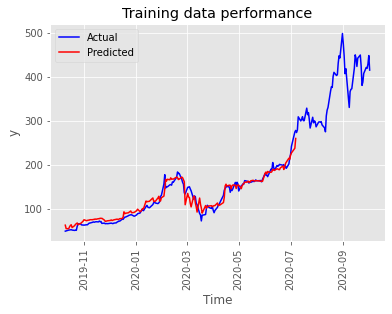

In [30]:
plt.plot(data['Close'].iloc[window_size:],color='b',label='Actual')
plt.plot(data.index[window_size:x_train_size+window_size],np.array(out_train),color='r',label='Predicted')
plt.title('Training data performance')
plt.xlabel('Time')
plt.ylabel('y')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

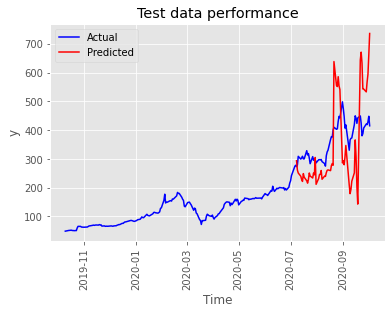

In [31]:
plt.plot(data['Close'].iloc[window_size:],color='b',label='Actual')
plt.plot(data.index[x_train_size+window_size:],np.array(out_test),color='r',label='Predicted')
plt.title('Test data performance')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.ylabel('y')
plt.legend()
plt.show()